# Final project
The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

## Step 3

Solve the problem for all combinations of

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

# Project implementation
First we import the needed python libraries

In [2]:
%pylab inline
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot
from IPython.display import Image
from IPython.display import display, clear_output
import time

Populating the interactive namespace from numpy and matplotlib


*The Allen–Cahn equation $
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0
$ is a reaction–diffusion equation which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.*

*The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$. *

*The double well potential is given by the following function*
$$
f(\eta) = \eta^2(\eta-1)^2
$$
Before to start, let's represent graphically this function over it's interval of definition

In [3]:
def f(eta):    # This is the double well potential function
    return eta**2*(eta-1)**2

To represent f over it's whole interval of definition, we split the interval $\Omega=[0,1]$ in `n_space` intervals, of dimension `dl = T/n_space`.

In [4]:
n_space=500
Omega=linspace(0,1,n_space)
dl=1/n_space

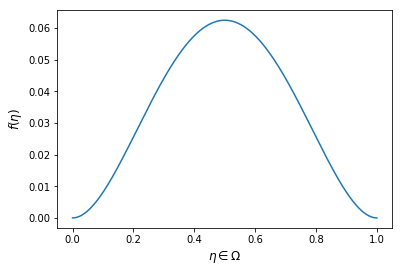

In [5]:
_ = plot(Omega,f(Omega))
_ = plt.ylabel(r"$f ( \eta )$", fontsize = 12)
_ = plt.xlabel(r"$\eta \in \Omega$", fontsize = 12)

As announced, $f$ "*has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.*"

In preparation of the exercise to be done, we define and split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. 

In [6]:
T=1
n_steps=100
dt=T/n_steps
Time=linspace(0,T,n_steps)

## Step 1

*Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step*
#### 1.1 Double potential derivative
*Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.*

Given the definition of the double well potential $
f(\eta) = \eta^2(\eta-1)^2
$, it's derivative is the following function:
$$
f'(\eta) = F(\eta)= \frac{d(\eta^2)} {d \eta} \times(\eta-1)^2+ \eta^2\times\frac{d (\eta-1)^2}{d\eta}\\
=2\eta\times(\eta-1)^2 + \eta^2\times2(\eta-1)
$$

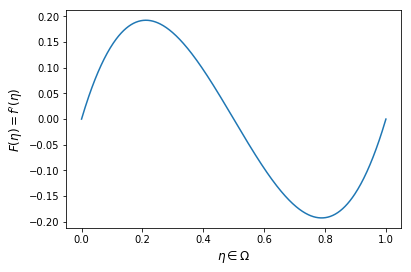

In [7]:
def F(eta): # derivative of the double well potential function
    return 2*eta*(eta-1)**2+eta**2*2*(eta-1)
_ = plot(Omega,F(Omega))
_ = plt.ylabel(r"$F(\eta) = f'(\eta) $", fontsize = 12)
_ = plt.xlabel(r"$\eta \in \Omega$", fontsize = 12)

#### 1.2. Basis functions
*Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`.*

In [8]:
def compute_basis_functions(support_points, degree):
    # Insert here what was in notebook 9
    basis = []
    dbasis = []
    for i in range(len(support_points)):
        c = support_points*0 # c has same shape as support_points but is null
        c[i] = 1 # c is null everywhere except in one of the support_points
        bi = PPoly.from_spline(splrep(support_points,c,k=degree))
        basis.append(bi)# append base basis function to basis matrix
    return basis

*The basis functions are constructed from the spline interpolation by computing the piecewise interpolation of a function that has value one in one of the `support_points` and zero in all other support points.*

There are as many basis functions as support points, that is, `ndofs`. They define a basis for a piecewise polynomial space of dimension `ndofs`.

In [9]:
ndofs=16
degree=2

Lets visualize this basis functions and use them to plot a piecewise polynomial interpolation of $f$ in $\Omega$

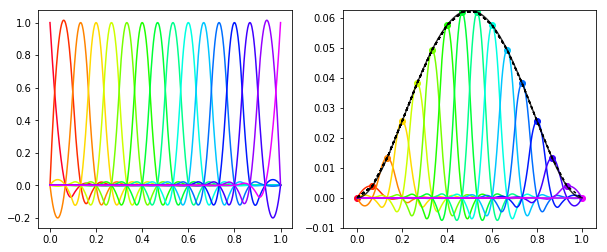

In [10]:
support_points=linspace(0,1,ndofs)
BasisFunctions=compute_basis_functions(support_points,degree)
OmegaBasisMat=zeros((n_space,ndofs))
for i in range(len(support_points)):
    OmegaBasisMat[:,i]=BasisFunctions[i](Omega)
    

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

ylim(-0.01,max(f(Omega)))
for i in range(ndofs):
    BasisFunc=BasisFunctions[i]
    ax[0].plot(Omega,BasisFunc(Omega),color=cm.gist_rainbow(i/ndofs)) # plot this basis function
    ax[1].plot(Omega,OmegaBasisMat[:,i:i+1].dot(f(support_points[i:i+1])),color=cm.gist_rainbow(i/ndofs)) # plot this basis function
    ax[1].scatter(support_points[i],f(support_points)[i:i+1],color=cm.gist_rainbow(i/ndofs))
    ax[1].plot(support_points[:i+1],f(support_points)[:i+1],'k',dashes=[2,2,2,2]) 
    clear_output() 
    display(fig)
    time.sleep(2.0/float(ndofs))
clear_output() 
display(fig)
time.sleep(0.5)
_ = ax[1].plot(Omega,f(Omega),'k',alpha=0.8)
clear_output() 
display(fig)
clear_output() 

.

.

.

.

.

.

.

#### 1.3. Global quadrature
*Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`*

 Gauss quadrature uses the function values evaluated at the `n_gauss_quadrature_points` and corresponding weights to approximate the integral by a weighted sum. Gauss quadrature deals with integration for $x \in [-1,1]$,  consequently we have to rescale the points and weights to work from zero to one. 

In [11]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    # Create a Gauss quadrature formula with n_gauss_quadrature_points, 
    # extract the intervals from basis (i.e., unique(basis.x)), and 
    # create len(x)-1 shifted 
    # and scaled Gauss quadrature formulas 
    # that can be used to integrate on each interval. 
    # Put all of these 
    # together, and return the result
    

    # The intervals are stored as `x`  (with some repeated entries)
    # in the `PPoly` object. Thats why we use unique() to make sure
    # that every interval border is taken only once
    intervals = unique(basis[0].x) 

    # and make sure we can integrate exactly the product 
    # of two basis functions
    qp, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    
    # Rescale the points and weights to work from zero to one
    qp = (qp+1)/2
    w /= 2
    
    # Now replicate these points and weights in all the intervals
    h = diff(intervals) # 1st order discrete difference 
    Q = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    W = array([w*h[i] for i in range(len(h))]).reshape((-1,))
  
    # return global_quadrature, global_weights
    return Q,W

Text(0,0.5,'global weights')

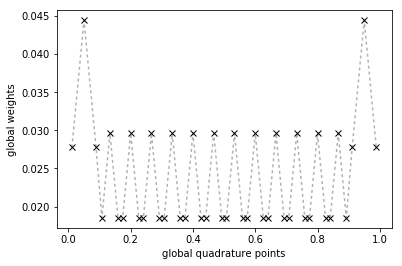

In [12]:
Q,W= compute_global_quadrature(BasisFunctions,degree +1)
plot(Q,W,'k',dashes=[2,2,2,2],alpha=0.3)
plot(Q,W,'xk')
xlabel("global quadrature points")
ylabel("global weights")

#### 1.4 Compute M and K
*Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ *

In [13]:
# Step 1.4

def compute_system_matrices(basis, global_quadrature, global_weights):
    # Compute the matrices M_ij = (v_i, v_j) and K_ij = (v_i', v_j') and return them
    
    #compute the 1st derivative of the basis functions
    dbasis = []
    nB=len(basis)
    for i in range(nB):
        dbasis.append( basis[i].derivative(1) )

    Bq = array([basis[i](global_quadrature) for i in range(nB)]).T
    dBq = array([dbasis[i](global_quadrature) for i in range(nB)]).T
    M = einsum('qi, q, qj', Bq, global_weights, Bq)
    K = einsum('qi, q, qj', dBq, global_weights, dBq)
    # return M, Kn-th order discrete difference 
    return M,K

Text(0.5,1,'K matrix')

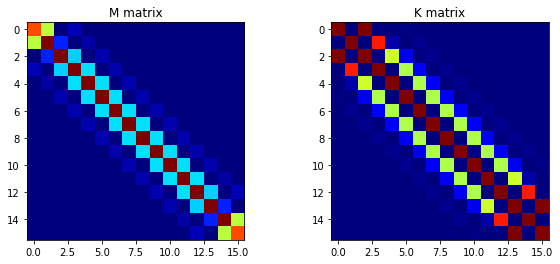

In [14]:
M,K=compute_system_matrices(BasisFunctions, Q,W)
shape(support_points)
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,4))
ax[0].imshow(M,cm.jet,vmin=0,vmax=0.02)
ax[0].set_title("M matrix")
ax[1].imshow(K,cm.jet,vmin=0,vmax=2)
ax[1].set_title("K matrix")

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution


In [15]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    # put together all the above functions, loop over time, and produce  
    # the result matrix eta, containing the solution at all points
    support_points=linspace(0,1,ndofs)
    
    basis=compute_basis_functions(support_points, degree)
    Q,W= compute_global_quadrature(basis,degree +1)
    M,K=compute_system_matrices(basis, Q,W)
    
    #A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij}
    A = M + dt * eps**2 * K
    
    ntime=int(1.0/dt)
    
    eta=zeros((ntime, ndofs),dtype=float)
    # store initial values in eta
    eta[0,:]=eta_0_function(support_points)
    
    for k in range(ntime-1):
        # b_i = M_{ij} (eta_k^j - Delta_t f'(eta_k^j) )
        b = M.dot( eta[k] - dt *F(eta[k]) )
        # A.eta_k+1 = b
        eta[k+1,:]=np.linalg.solve(A,b)
    
    return eta, basis

#### 2.2. plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$
Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one


In [16]:
# Step 2.2 

def plot_solution(eta, basis, stride, resolution):
    x = linspace(0,1,resolution)
    BasisMatrix=np.zeros((resolution,len(basis)))
    for i in range(len(basis)):
        BasisMatrix[:,i]=basis[i](x)

    fig,ax=plt.subplots(figsize=(8,4))
    for k in range(0,len(eta)):#,stride):
        label="t="+str(k/len(eta))
        if( (k/len(eta))%0.1!=0):label=''
        ax.plot(x , eta[k,:].dot(BasisMatrix.T),color=cm.jet(k/len(eta)),label=label)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        clear_output() 
        display(fig)
        time.sleep(2.0*1.0/float(len(eta)))
    ax.plot(x ,  eta[-1,:].dot(BasisMatrix.T),color='k',label="t=1",dashes=[2,2,2,2])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    display(fig)
    clear_output() 



## Step 3

*Solve the problem for all combinations of*

*1. eps = [01, .001]*

*2. ndofs = [16, 32, 64, 128]*

*3. degree = [1, 2, 3]*

*3. dt = [.25, .125, .0625, .03125, .015625]*

*with $\eta_0 = \sin(2 \pi x)+1$.*

*Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? *

In [17]:
def eta_0(x):
    return sin(2*pi*x)+1

Text(0.5,1,'Degree=2 ndofs=64 Small eps = 0.001 and small dt= 0.05')

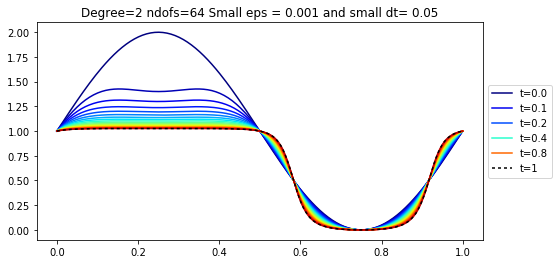

In [19]:
eps=.001
degree=2
ndofs=64
dt=0.05
eta,basis=solve_allen_cahan(eta_0, eps, dt, ndofs, degree)
stride=4
plot_solution(eta,basis,stride,200)
plt.title("Degree="+str(degree)+" ndofs="+str(ndofs)+" Small eps = "+str(eps)+" and small dt= "+str(dt))

.

.

.

.

.

.

Text(0.5,1,'Degree=3 ndofs=128 Larger eps = 0.01 and Larger dt = 0.25')

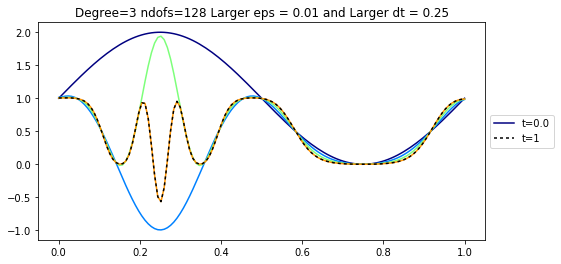

In [20]:
eps=.01
degree=3
ndofs=128
dt=0.25
eta,basis=solve_allen_cahan(eta_0, eps, dt, ndofs, degree)
stride=1
plot_solution(eta,basis,stride,ndofs)
plt.title("Degree="+str(degree)+" ndofs="+str(ndofs)+" Larger eps = "+str(eps)+" and Larger dt = "+str(dt))

.

.

.

.

.

.

The plots below show the influence of the different parameters within the ranges requested. We can see the convergence of the approximated solution increases with the increase of the number of degrees of freedom and the reduction of the timestep. 

More precisely :

- the **degree** is represented by the different versions of dashes on the plot below:
 - degree **1** corrisponds to the curves with small hashes, 
 - degree **2** to the dong dashes,
 - degree **3** to the continuous lines. 
 
 The continuous and dashed lines are almost always superposed, indicating that the degrees used are almost not influent on the result at t=1. A very light effect can be visible only for the smallest numbers of degree of freedom **ndofs** or for large timesteps **dt**.
 
 
- the largest is the characteristic width of the phase transition **eps**, the smaller is the **dt** required to observe convergence of the approximated solution towards the exact solution . 
In facts for the smallest values of the phase transition $\varepsilon$, the convergence of the problem modeled in this exercise requires $dt \le 0.0625$, while for the largest values of $\varepsilon$ a timestep $dt\le 0.125$ is almost sufficient. Choosing too large **dt** the solution experiences oscillations.


- increasing the number of degrees of freedom **ndofs** while keeping **dt** constant leads to smoother functions, removing some "local" variations of the solution respecto to the converged solution (specially for the smallest values of $\varepsilon$ that induce a sharper solution). But this doesn't change the global shape of the result, except for very large **dt** but for the largest **dt** the approximation is anyway far to be good.

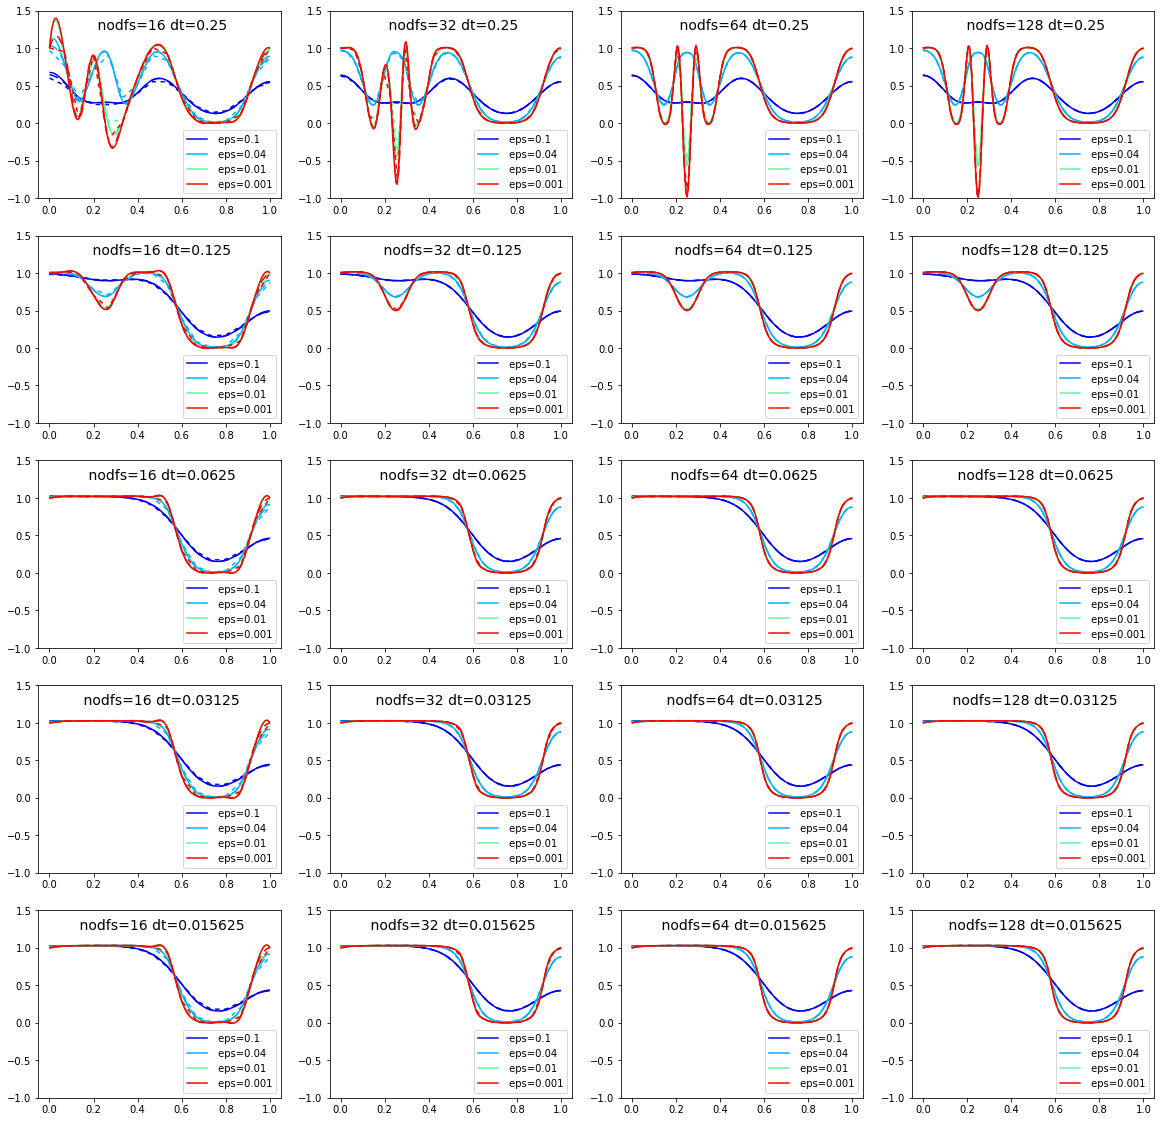

In [21]:
def plot_t1(eta, basis, stride, resolution,ax,color,dashes):
    x = linspace(0,1,resolution)
    BasisMatrix=np.zeros((resolution,len(basis)))
    for i in range(len(basis)):
        BasisMatrix[:,i]=basis[i](x)
    if(dashes!=[1,0,1,0]):label=''
    ax.plot(x , eta[-1,:].dot(BasisMatrix.T),color=color,dashes=dashes)
    #ax.legend(loc='lower right')
    #ax.set_title(title)
    ax.set_ylim(-1,1.5)
    
epslist=[0.1,0.04,0.01,.001]
deglist=[1,2,3]
ndofslist=[16, 32, 64, 128]
dtlist=[.25, .125, .0625, .03125, .015625]
fig,ax=plt.subplots(nrows=5,ncols=4,figsize=(20,20))
for col,ndofs in enumerate(ndofslist):
    for row,dt in enumerate(dtlist):
        ax[row,col].text(.5,.9," nodfs="+str(ndofs)+" dt="+str(dt),
            horizontalalignment='center',
            transform=ax[row,col].transAxes,fontsize=14)
        for eps,color in zip(epslist,cm.jet([0.1,.30,0.45,0.9])):
            ax[row,col].plot(0,0,color=color,label=" eps="+str(eps))
            ax[row,col].legend(loc='lower right')
            for degree,dash in zip(deglist,([3,3,3,3],[6,4,6,4],[1,0,1,0])):
                eta,basis=solve_allen_cahan(eta_0, eps, dt, ndofs, degree)
                plot_t1(eta,basis,stride,200,ax[row,col],color,dash)